# Вебинар 5. Обучение без учителя.

**План занятия**
* [Введение](#intro)
* [Понижение размерности](#reduce)
    * [PCA -  Principal Component Analysis](#pca)
    * [TSNE](#tsne)
* [Кластеризация](#cluster)
    * [K-means](#kmeans)
    * [DBSCAN](#dbscan)
    * [Иерархическая](#aggl)
* [Наглядный пример](#example)
* [Задание для курсового проекта](#course)

## Введение <a class='anchor' id='intro'>

1. Кластеризация - разделение данных на группы<br>
Сегментирование данных
<img src='images/clusters.png' width=700px>
2. Понижение размерности - из N фичей сделать 2 или 3, и визуализировать<br>
**Для чего может быть полезно понижение размерности:**

*1. Визуализация*

Тяжело визуализировать многомерное пространство
<img src='images/6dims.png' width=300>
*2. Сжатие с сохранением смысла*

Все признаки важные, отбрасывать их нельзя, но можно их сжать
<img src='images/pca_reduce.png' width=300>
*3. Абстрактные признаки*

Получить новые признаки на основе старых
<img src='images/retail.png' width=500>

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})

In [3]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [4]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [5]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [6]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [7]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = './housing_prepared_lmv.csv'
TRAIN_DATASET_EXT_PATH = './housing_train_ext.csv'

### Загрузка данных

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [9]:
df = pd.read_csv(TRAIN_DATASET_PATH, ';')
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   ...  bedroom_share  population_per_room  <1H OCEAN  INLAND  ISLAND  \
0  ...      14.659091             0.365909          0       0       0   
1  ...      15.579659             0.338217          0       0       0   
2  ...      12.951602             0.338105          0       0       0   
3  ...      18.445840             0.437991          0       0       0   
4  ...      17.209588             0.347265          0       0       0   

   NEAR BAY  NEAR OCEAN  median_rooms  age_cat  age_binary_cat  
0         1           0         425.5        4               0  
1         1           0         425.5        3               0  
2         1           0         425.5        4               0  
3         1           0         425.5        4               0  
4         1           0         425.5        4               0  

[5 rows x 26 columns]

In [10]:
df.dtypes

longitude                 float64
latitude                  float64
housing_median_age        float64
total_rooms               float64
total_bedrooms            float64
population                float64
households                float64
median_income             float64
median_house_value        float64
ocean_proximity            object
housing_median_age_nan      int64
total_bedrooms_nan          int64
population_nan              int64
ocean_proximity_nan         int64
longitude_outlier           int64
latitude_outlier            int64
bedroom_share             float64
population_per_room       float64
<1H OCEAN                   int64
INLAND                      int64
ISLAND                      int64
NEAR BAY                    int64
NEAR OCEAN                  int64
median_rooms              float64
age_cat                     int64
age_binary_cat              int64
dtype: object

### Определение признакового пространства

In [11]:
X = df.drop(['median_house_value','ocean_proximity'], axis=1)
y = df['median_house_value'].values

X.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   

   population  households  median_income  housing_median_age_nan  \
0       322.0       126.0         8.3252                       0   
1      2401.0      1138.0         8.3014                       0   

   total_bedrooms_nan  ...  bedroom_share  population_per_room  <1H OCEAN  \
0                   0  ...      14.659091             0.365909          0   
1                   0  ...      15.579659             0.338217          0   

   INLAND  ISLAND  NEAR BAY  NEAR OCEAN  median_rooms  age_cat  age_binary_cat  
0       0       0         1           0         425.5        4               0  
1       0       0         1           0         425.5        3               0  

[2 rows x 24 columns]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## Масштабирование / Нормализация

$$dist(x, y) = \sqrt(\sum(x_i - y_i)^2)$$ 

In [13]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) [0,1]
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = RobustScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.152632 -0.055556            0.277778    -0.138070       -0.037223   
1  -0.597368  0.939153           -0.666667     1.407507        0.841804   

   population  households  median_income  housing_median_age_nan  \
0    0.072383     0.11315       0.062717                     0.0   
1    0.717149     0.82263      -0.118998                     0.0   

   total_bedrooms_nan  ...  bedroom_share  population_per_room  <1H OCEAN  \
0                 0.0  ...       0.234973             0.529256        1.0   
1                 0.0  ...      -0.454467            -0.369035        0.0   

   INLAND  ISLAND  NEAR BAY  NEAR OCEAN  median_rooms  age_cat  age_binary_cat  
0     0.0     0.0       0.0         0.0           0.0      0.0             0.0  
1     1.0     0.0       0.0         0.0          -1.0     -1.0             0.0  

[2 rows x 24 columns]

В _scaled все признаки измеряются в одних единицах

In [14]:
X_train_scaled.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  13828.000000  13828.000000        13828.000000  13828.000000   
mean      -0.281309      0.365776           -0.015729      0.211292   
std        0.527779      0.566562            0.687435      0.906236   
min       -1.534211     -0.457672           -1.555556     -1.176944   
25%       -0.868421     -0.087302           -0.555556     -0.408847   
50%        0.000000      0.000000            0.000000      0.000000   
75%        0.131579      0.912698            0.444444      0.591153   
max        1.107895      2.031746            1.277778      3.982574   

       total_bedrooms    population    households  median_income  \
count    13828.000000  13828.000000  13828.000000   1.382800e+04   
mean         0.295813      0.280375      0.278644   1.601577e-01   
std          1.199812      1.232338      1.169555   8.800706e-01   
min         -1.242663     -1.293987     -1.250765  -1.381915e+00   
25%         -0.392269     -0.407572     -0.394495  -4.419390e-01   
50%          0.000000      0.000000      0.000000  -1.013594e-16   
75%          0.607731      0.592428      0.605505   5.580610e-01   
max         16.535433     38.437639     15.131498   5.236763e+00   

       housing_median_age_nan  total_bedrooms_nan  ...  bedroom_share  \
count            13828.000000        13828.000000  ...   1.382800e+04   
mean                 0.035725            0.010052  ...   3.631237e-01   
std                  0.185609            0.099758  ...   2.263837e+00   
min                  0.000000            0.000000  ...  -2.965956e+00   
25%                  0.000000            0.000000  ...  -4.302072e-01   
50%                  0.000000            0.000000  ...  -2.593886e-16   
75%                  0.000000            0.000000  ...   5.697928e-01   
max                  1.000000            1.000000  ...   3.966015e+01   

       population_per_room     <1H OCEAN        INLAND        ISLAND  \
count         1.382800e+04  13828.000000  13828.000000  13828.000000   
mean          4.546398e-01      0.439471      0.316966      0.000217   
std           2.015442e+00      0.496341      0.465311      0.014728   
min          -2.173638e+00      0.000000      0.000000      0.000000   
25%          -3.575023e-01      0.000000      0.000000      0.000000   
50%           2.348492e-16      0.000000      0.000000      0.000000   
75%           6.424977e-01      1.000000      1.000000      0.000000   
max           6.879299e+01      1.000000      1.000000      1.000000   

           NEAR BAY    NEAR OCEAN  median_rooms       age_cat  age_binary_cat  
count  13828.000000  13828.000000  13828.000000  13828.000000    13828.000000  
mean       0.113248      0.130098     -0.058810     -0.500506        0.025889  
std        0.316908      0.336424      1.241547      0.706979        0.158811  
min        0.000000      0.000000     -1.055556     -3.000000        0.000000  
25%        0.000000      0.000000     -1.000000     -1.000000        0.000000  
50%        0.000000      0.000000      0.000000      0.000000        0.000000  
75%        0.000000      0.000000      0.000000      0.000000        0.000000  
max        1.000000      1.000000      8.555556      0.000000        1.000000  

[8 rows x 24 columns]

Когда **необходимо** применять масштабирование/нормализацию:
- Во всех методах понижения размерности
- В линейной регрессии
- В KNN

Когда **не обязательно** использовать масштабирование/нормализацию:
- Дерево решений
- Случайный лес
- Градентный бустинг

## Понижение размерности <a class='anchor' id='reduce'>

### PCA -  Principal Component Analysis (метод главных компонент) <a class='anchor' id='pca'>

**Из 2-мерного пространства в 1-мерное**

фичи X1, X2

$$component_1 = a_1*X_1 + a_2*X_2$$

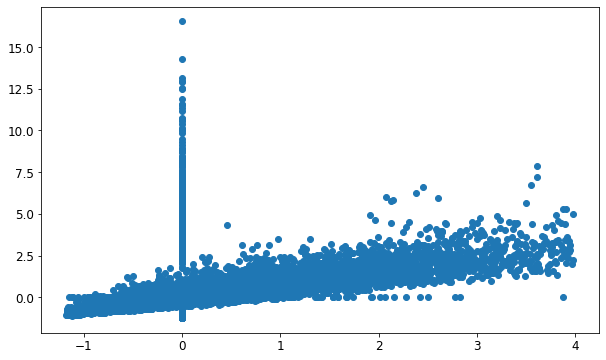

In [15]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.show()

In [16]:
X_small.head()

total_rooms  total_bedrooms  component_1
0    -0.138070       -0.037223    -0.467807
1     1.407507        0.841804     1.098394
2    -0.102547        0.085898    -0.344641
3    -0.993298       -0.890480    -1.645164
4     0.168231        0.209019    -0.096405

PCA подбирает такую линию, вдоль которой лежат точки

В линейной регресии вы минимизируете "вертикальную разницу":
    $$(y - y_{pred})^2$$
    
В PCA вы минимизируете среднее расстояние от точек до линии - перпендикуляр к линии:
$$ \sqrt(x1_{i} - x1'_{i})^2 + (x2_{i} - x2'_{i})^2$$

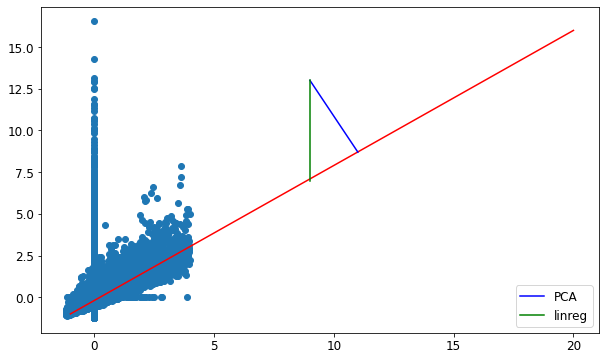

In [17]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.plot([-1, 20], [-1, 16], c='r')
plt.plot([9, 11], [13, 8.7], c='b', label='PCA')
plt.plot([9, 9], [13, 7], c='g', label='linreg')
plt.legend()
plt.show()

**Как работает PCA из 3d в 2d**

<img src="images/pca_1.png">

**Снижение размерности до 2х компонент**

In [18]:
import inspect
print(inspect.getsource(reduce_dims))

def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 



In [19]:
reduce_dims(X_train_scaled, dims=2, method='pca')

(PCA(n_components=2, random_state=42),
        component_1  component_2
 0        -0.281466     0.615520
 1        -0.441206    -1.874300
 2        -0.681251     0.540391
 3        -2.074966     1.516146
 4        -1.000479     0.188115
 ...            ...          ...
 13823    11.022109     0.396785
 13824    -0.341462    -2.233113
 13825    -0.122040    -0.447535
 13826    10.945709     0.596141
 13827    -0.702952    -0.712453
 
 [13828 rows x 2 columns])

In [20]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

component_1  component_2
0    -0.281466      0.61552
1    -0.441206     -1.87430

In [21]:
X_train_scaled.shape, components_2d.shape

((13828, 24), (13828, 2))

In [22]:
dim_reducer2d

PCA(n_components=2, random_state=42)

In [23]:
dims = 2
components = dim_reducer2d.transform(X_test_scaled)
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_2d_test = pd.DataFrame(data = components, columns = colnames)
components_2d_test.head()

component_1  component_2
0     0.395426    -4.065704
1    -0.775238    -0.917174
2    -0.285595     0.481501
3    -1.023866     0.284297
4     0.531005    -1.573466

In [24]:
print(inspect.getsource(display_components_in_2D_space))

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()



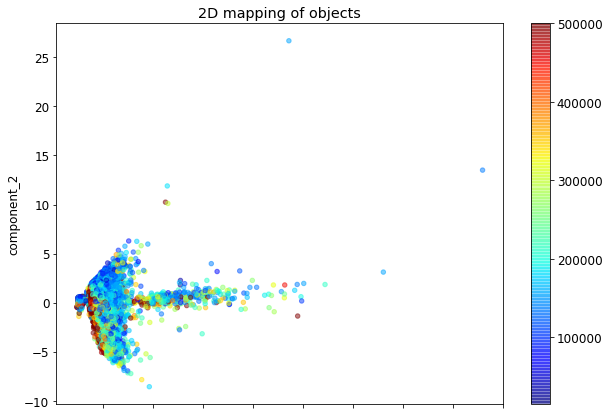

In [25]:
display_components_in_2D_space(components_2d, y_train)

**Снижение размерности до 3х компонент**

In [26]:
dim_reducer3d, components_3d = reduce_dims(X_train_scaled, dims=3, method='pca')

In [27]:
dims = 3
components = dim_reducer3d.transform(X_test_scaled)
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_3d_test = pd.DataFrame(data = components, columns = colnames)
components_3d_test.head()

component_1  component_2  component_3
0     0.395426    -4.065704     2.877218
1    -0.775238    -0.917174     0.284682
2    -0.285595     0.481501    -0.906466
3    -1.023866     0.284297     3.067559
4     0.531005    -1.573466     0.249695

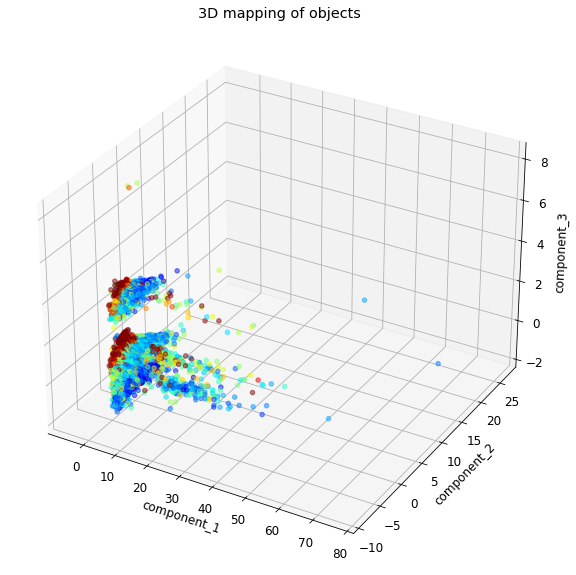

In [28]:
display_components_in_3D_space(components_3d, y_train)

## TSNE <a class='anchor' id='tsne'>

Объяснение можно посмотреть [здесь](https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/) или [здесь](https://habr.com/ru/post/267041/)

Принцип работы метода t-SNE заключается в том, что он пытается сохранять расстояния между каждым входящим вектором.

Шаг 1: В многомерном пространстве создается вероятностное распределение, которое обусловлено расстоянием между точками (преобразование многомерной дистанции между точками в условные вероятности, отражающие сходство точек)

Шаг 2: Алгоритм пытается воссоздать меньше размерное пространство, в котором наилучшим образом сохраняется вероятностное распределение

In [29]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=1)
components_2d_tsne.head(2)

CPU times: user 10min 23s, sys: 29 s, total: 10min 52s
Wall time: 42.8 s


component_1  component_2
0   -32.779305   -42.114697
1    60.093082   -34.485332

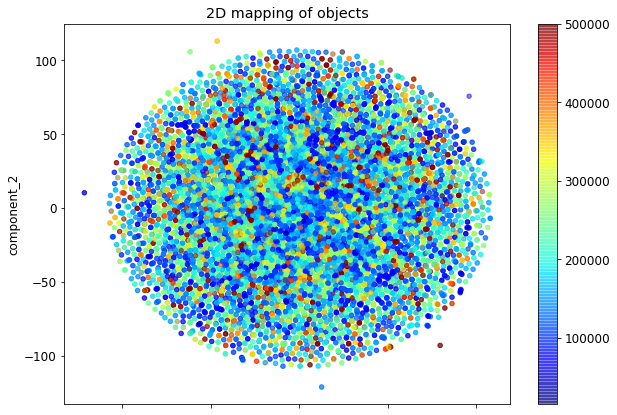

In [30]:
display_components_in_2D_space(components_2d_tsne, y_train)

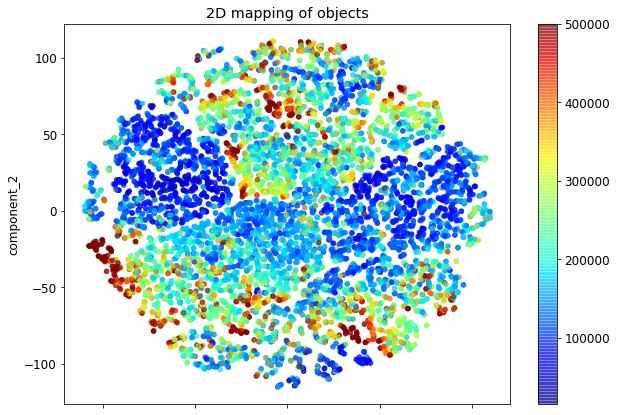

CPU times: user 8min 35s, sys: 8.52 s, total: 8min 44s
Wall time: 34.7 s


In [31]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=5)
display_components_in_2D_space(components_2d_tsne, y_train)

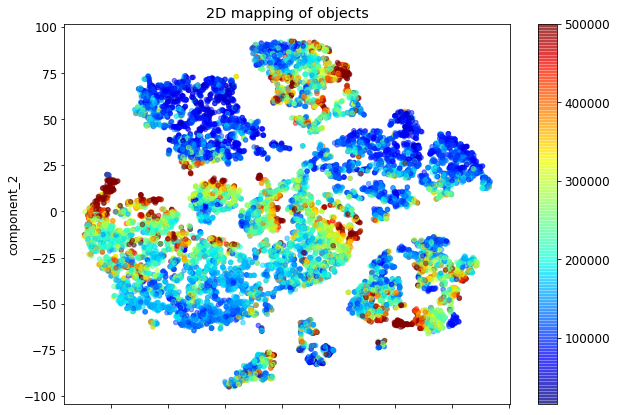

CPU times: user 10min 56s, sys: 11.1 s, total: 11min 7s
Wall time: 44.9 s


In [32]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=30)
display_components_in_2D_space(components_2d_tsne, y_train)

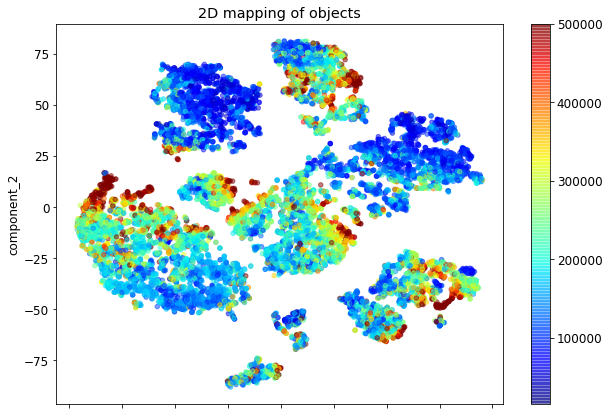

CPU times: user 12min 40s, sys: 12.8 s, total: 12min 52s
Wall time: 52.2 s


In [33]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=50)
display_components_in_2D_space(components_2d_tsne, y_train)

In [34]:
%%time
dim_reducer3d_tsne, components_3d_tsne = reduce_dims(X_train_scaled, dims=3, method='tsne')
components_3d_tsne.head(2)

CPU times: user 18min 22s, sys: 12.1 s, total: 18min 34s
Wall time: 1min 12s


component_1  component_2  component_3
0    -6.993242    -8.762442    -4.668701
1    18.246016     2.316473     1.136114

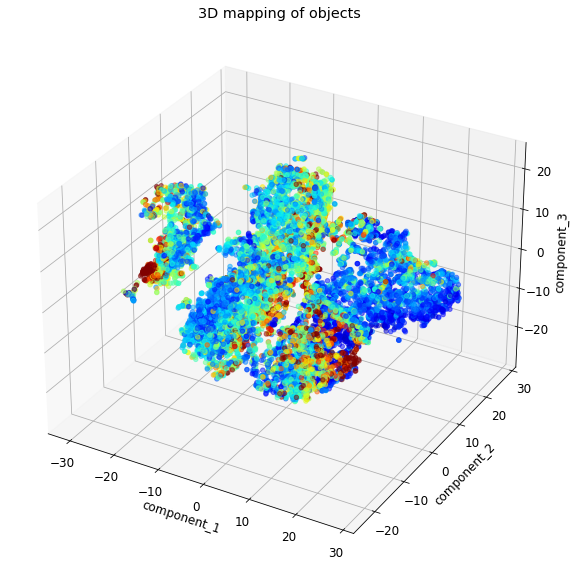

In [35]:
display_components_in_3D_space(components_3d_tsne, y_train)

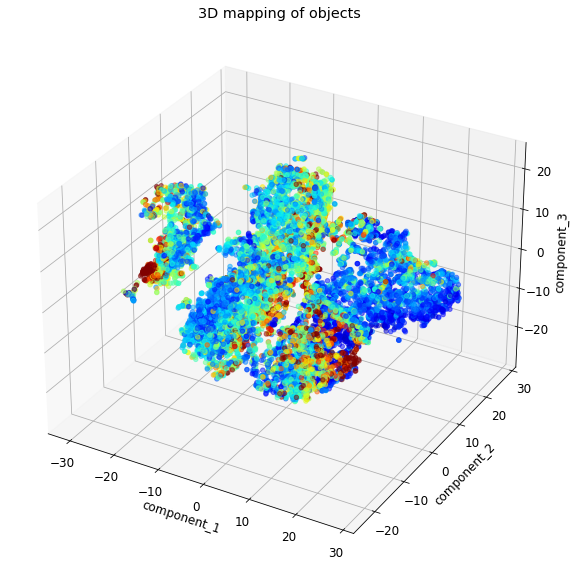

In [36]:
display_components_in_3D_space(components_3d_tsne, y_train)

# Кластеризация <a class='anchor' id='cluster'>

Алгоритмы:
- K-means
- [Иерархическая кластеризация](https://towardsdatascience.com/https-towardsdatascience-com-hierarchical-clustering-6f3c98c9d0ca)
- [DBScan](https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a)

### Кластеризация: k-means <a class='anchor' id='kmeans'>

**Как работает k-means**

Вы указываете кол-во кластеров

1. Центры кластеров случайно инициализируются
2. От каждой точки рассчитывается расстояние до центра каждого кластера
3. Присваиваем каждую точку к тому кластеру, к центру которого она ближе
4. Пересчитываем центры кластеров: берем среднее по всем фичам --> новый центр кластера
    
итеративно повторяем шаги 2-4. Пока центры кластеров не перестанут "двигаться"

Хорошо работает, когда кластеры "шарообразные"

<img src="images/kmeans_v1.gif">

[Машинное обучение для людей](https://zen.yandex.ru/media/id/5c228ab268a70a00adaf792a/mashinnoe-obuchenie-dlia-liudei-5c23782132121100a94a4417) 

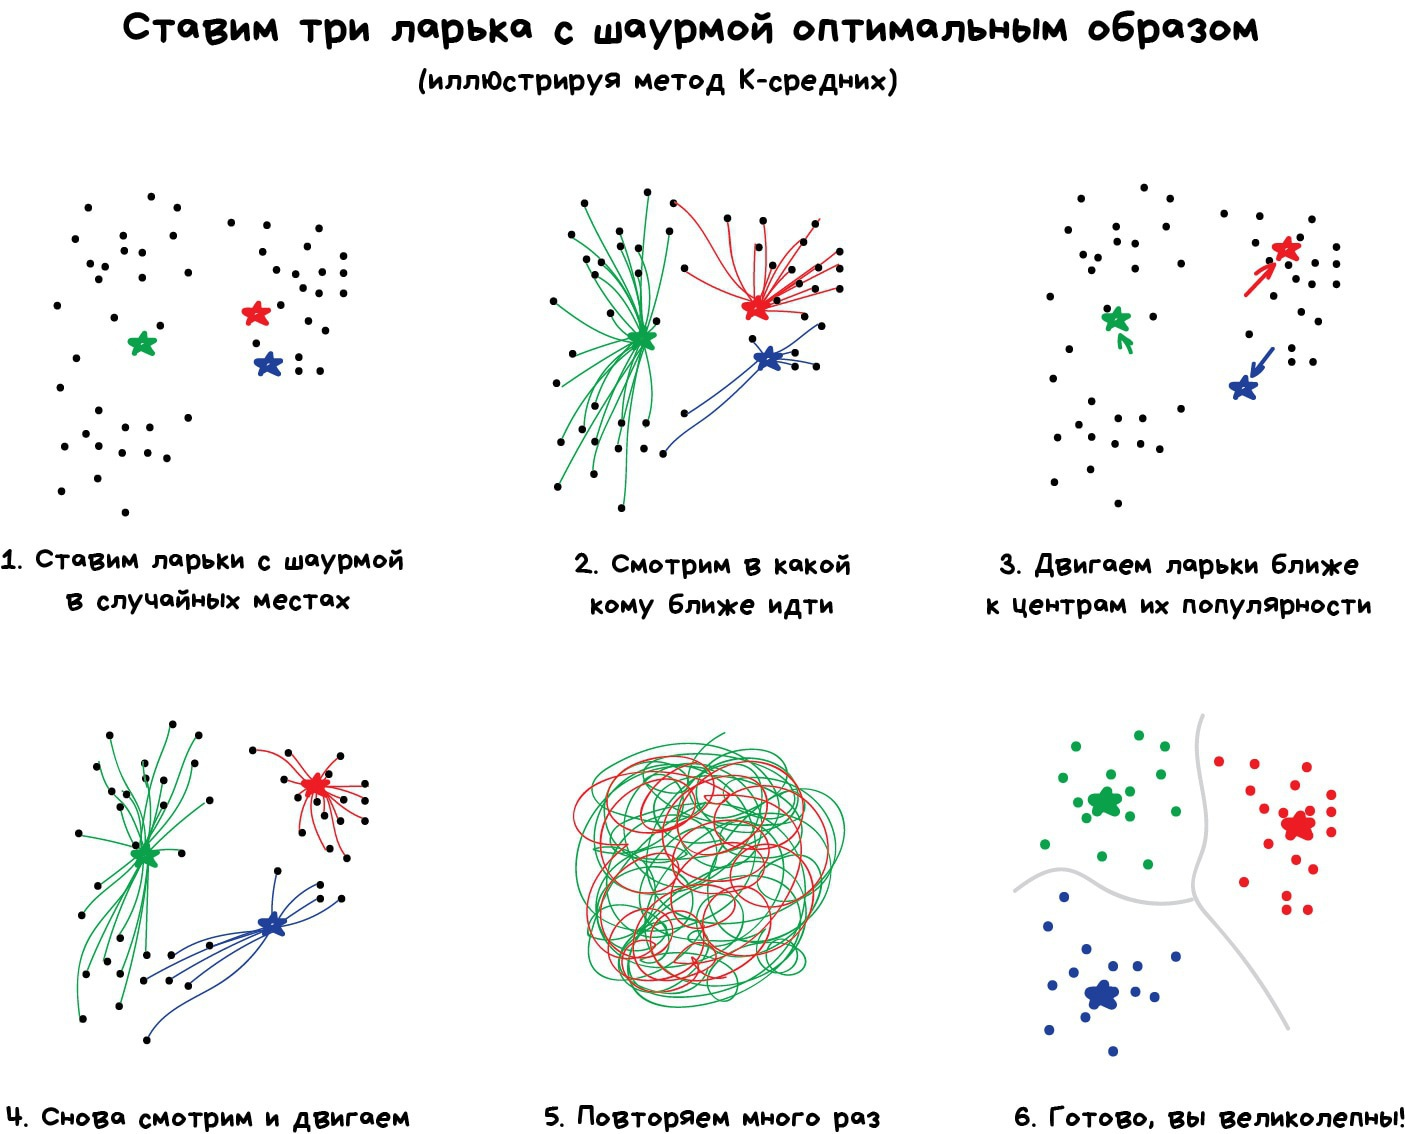 

**Выделение 3 кластеров**

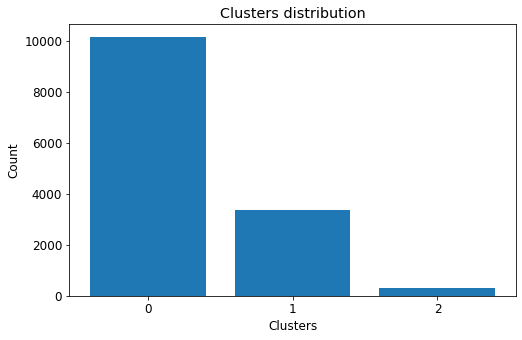

In [37]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(X_train_scaled)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')
labels_clast_3_test = kmeans_3.predict(X_test_scaled)
labels_clast_3_test = pd.Series(labels_clast_3_test, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

In [38]:
labels_clast_3[:5]

0    0
1    1
2    0
3    0
4    0
Name: clusters_3, dtype: int32

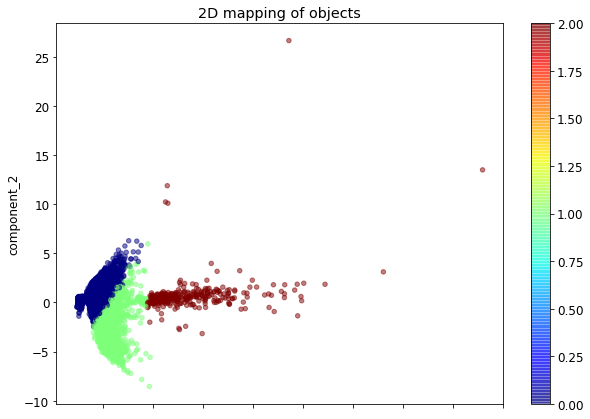

In [39]:
display_components_in_2D_space(components_2d, labels_clast_3)

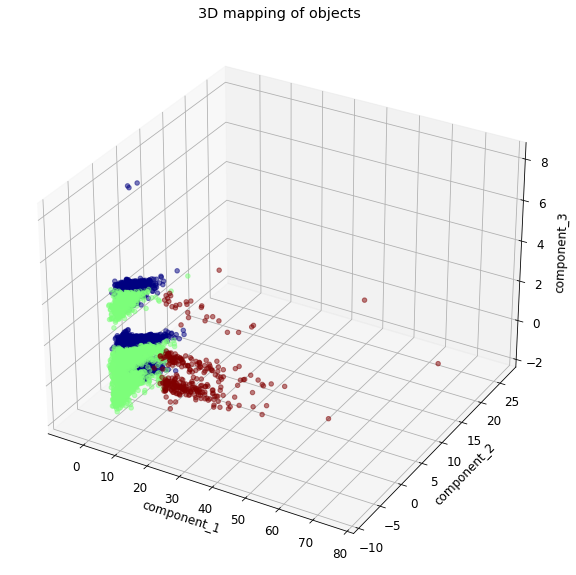

In [40]:
display_components_in_3D_space(components_3d, labels_clast_3)

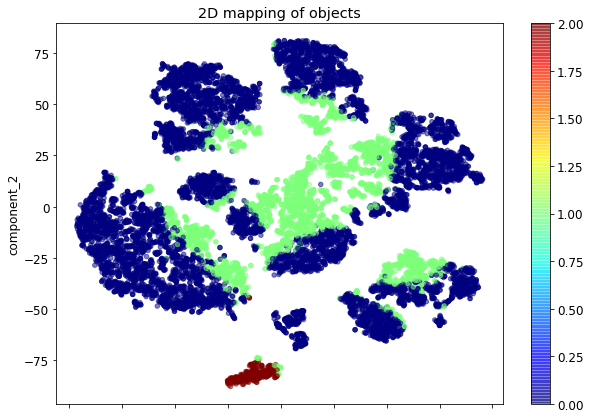

In [41]:
display_components_in_2D_space(components_2d_tsne, labels_clast_3)

In [42]:
kmeans_3.cluster_centers_

array([[-3.00849473e-01,  3.89135261e-01,  1.28371727e-01,
        -1.74571067e-01, -2.01343046e-01, -2.00043434e-01,
        -2.10418206e-01,  1.44985121e-01,  3.61291593e-02,
         1.02382359e-02,  3.14038196e-02,  1.08289033e-03,
         4.92222879e-04,  0.00000000e+00,  4.98810645e-03,
         2.16597615e-01,  4.26757236e-01,  3.23390431e-01,
         2.95333727e-04,  1.21086828e-01,  1.28470171e-01,
        -7.75415108e-02, -3.64146486e-01,  1.26993503e-02],
       [-2.35618624e-01,  3.04411321e-01, -3.71647510e-01,
         1.39694403e+00,  1.34810367e+00,  1.29125067e+00,
         1.32449901e+00,  1.70692089e-01,  3.38882283e-02,
         1.04042806e-02,  2.37812128e-02,  1.48632580e-03,
         1.02999206e-18,  0.00000000e+00,  3.31623102e-01,
         3.39456692e-01,  4.85434007e-01,  2.83888228e-01,
         5.14996032e-19,  9.15576694e-02,  1.39120095e-01,
         2.13700621e-02, -8.12722949e-01,  4.57788347e-02],
       [-1.34924321e-01,  2.64939309e-01, -8.86528686e

**Выделение 10 кластеров**

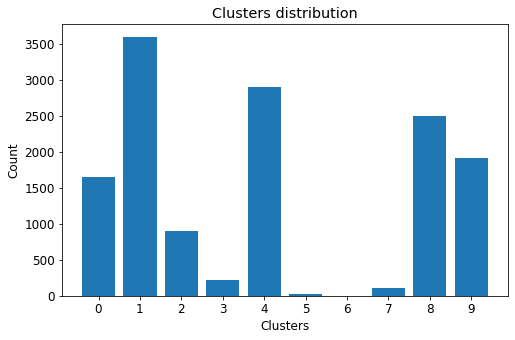

In [43]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
labels_clast_10 = kmeans_10.fit_predict(X_train_scaled)
labels_clast_10 = pd.Series(labels_clast_10, name='clusters_10')
labels_clast_10_test = kmeans_10.predict(X_test_scaled)
labels_clast_10_test = pd.Series(labels_clast_10_test, name='clusters_10')

unique, counts = np.unique(labels_clast_10, return_counts=True)
display_clusters_distribution(unique, counts)

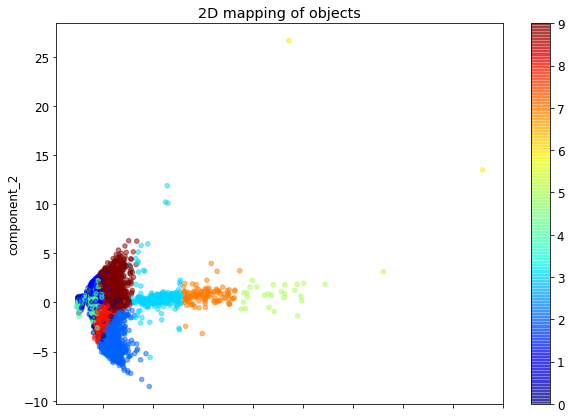

In [44]:
display_components_in_2D_space(components_2d, labels_clast_10)

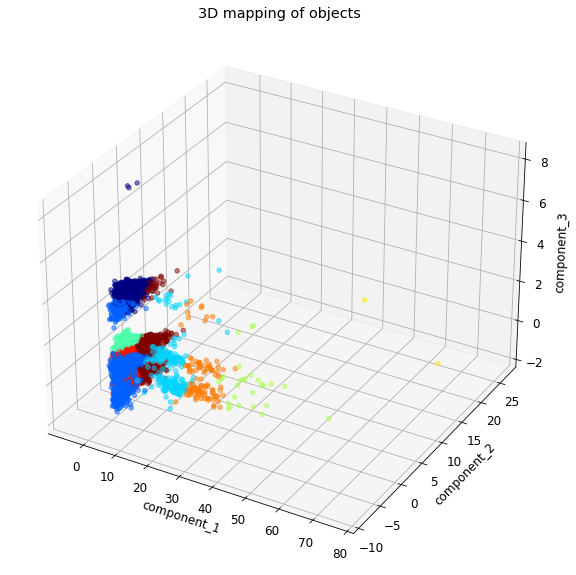

In [45]:
display_components_in_3D_space(components_3d, labels_clast_10)

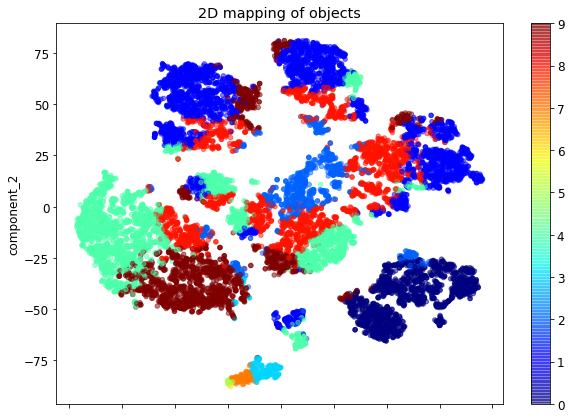

In [46]:
display_components_in_2D_space(components_2d_tsne, labels_clast_10)

### Оценка оптимального кол-ва кластеров

Дисперсия точек вокруг цетров кластеров

In [47]:
print(inspect.getsource(apply_elbow_method))

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()



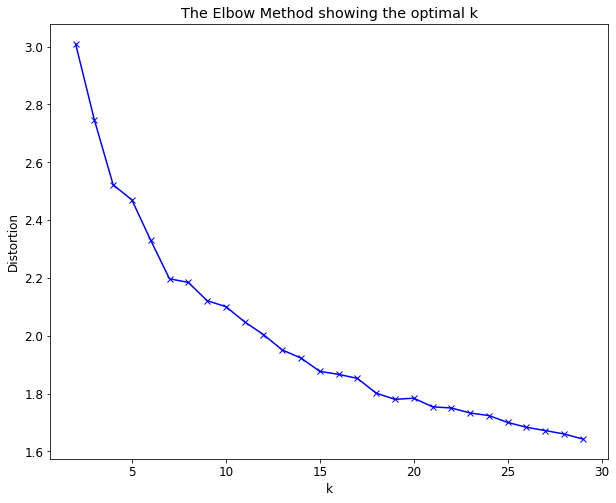

In [48]:
apply_elbow_method(X_train_scaled)

### Добавление новых признаков

In [49]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')
clusters_10_dummies = pd.get_dummies(labels_clast_10, drop_first=True, prefix='clusters_10')

X_train_cluster = pd.concat([X_train_scaled, components_3d, clusters_3_dummies, clusters_10_dummies], 
                   axis=1)
X_train_cluster.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.152632 -0.055556            0.277778    -0.138070       -0.037223   
1  -0.597368  0.939153           -0.666667     1.407507        0.841804   
2   0.128947 -0.076720            0.944444    -0.102547        0.085898   
3  -0.981579  0.846561            0.500000    -0.993298       -0.890480   
4  -0.950000  0.992063            1.277778     0.168231        0.209019   

   population  households  median_income  housing_median_age_nan  \
0    0.072383    0.113150       0.062717                     0.0   
1    0.717149    0.822630      -0.118998                     0.0   
2   -0.317372    0.094801      -0.351287                     0.0   
3   -1.002227   -0.938838       0.886160                     0.0   
4   -0.250557    0.125382      -0.259768                     0.0   

   total_bedrooms_nan  ...  clusters_3_2  clusters_10_1  clusters_10_2  \
0                 0.0  ...             0              0              0   
1                 0.0  ...             0              0              0   
2                 0.0  ...             0              0              0   
3                 0.0  ...             0              0              0   
4                 0.0  ...             0              1              0   

   clusters_10_3  clusters_10_4  clusters_10_5  clusters_10_6  clusters_10_7  \
0              0              1              0              0              0   
1              0              0              0              0              0   
2              0              1              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   clusters_10_8  clusters_10_9  
0              0              0  
1              1              0  
2              0              0  
3              0              0  
4              0              0  

[5 rows x 38 columns]

In [50]:
clusters_3_dummies_test = pd.get_dummies(labels_clast_3_test, drop_first=True, prefix='clusters_3')
clusters_10_dummies_test = pd.get_dummies(labels_clast_10_test, drop_first=True, prefix='clusters_10')

X_test_cluster = pd.concat([X_test_scaled, components_3d_test, clusters_3_dummies_test, clusters_10_dummies_test], 
                   axis=1)
X_test_cluster.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -0.984211  0.854497            0.833333     3.254692        1.992842   
1  -0.026316 -0.018519           -0.333333     0.650804        0.306371   
2   0.239474 -0.047619           -0.333333    -0.121984       -0.209019   
3  -0.168421  0.000000           -0.277778    -0.203083       -0.297781   
4   0.460526 -0.383598           -0.722222     1.046247        1.093772   

   population  households  median_income  housing_median_age_nan  \
0    1.840757    2.155963       0.958417                     0.0   
1    0.357461    0.250765       1.019673                     0.0   
2    0.354120   -0.082569       0.407659                     0.0   
3   -0.129176   -0.275229       1.091245                     0.0   
4    0.895323    1.091743      -0.297791                     0.0   

   total_bedrooms_nan  ...  clusters_3_2  clusters_10_1  clusters_10_2  \
0                 0.0  ...             0              0              1   
1                 0.0  ...             0              0              0   
2                 0.0  ...             0              1              0   
3                 0.0  ...             0              0              0   
4                 0.0  ...             0              0              0   

   clusters_10_3  clusters_10_4  clusters_10_5  clusters_10_6  clusters_10_7  \
0              0              0              0              0              0   
1              0              1              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   clusters_10_8  clusters_10_9  
0              0              0  
1              0              0  
2              0              0  
3              0              0  
4              1              0  

[5 rows x 38 columns]

### Переобучение и оценка финальной модели

In [51]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=400)
final_model.fit(X_train_cluster, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

R2:	0.966
MAE:	14741.883
MSE:	452308707.648


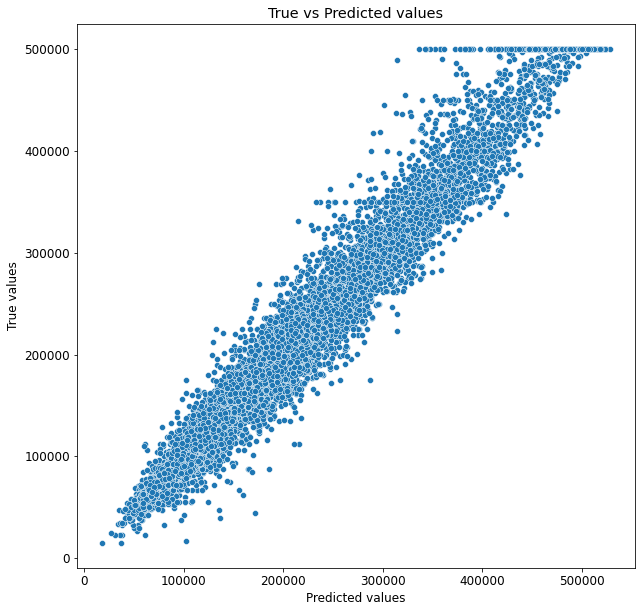

In [52]:
y_train_preds = final_model.predict(X_train_cluster)
evaluate_preds(y_train, y_train_preds)

R2:	0.839
MAE:	30125.143
MSE:	2085888650.923


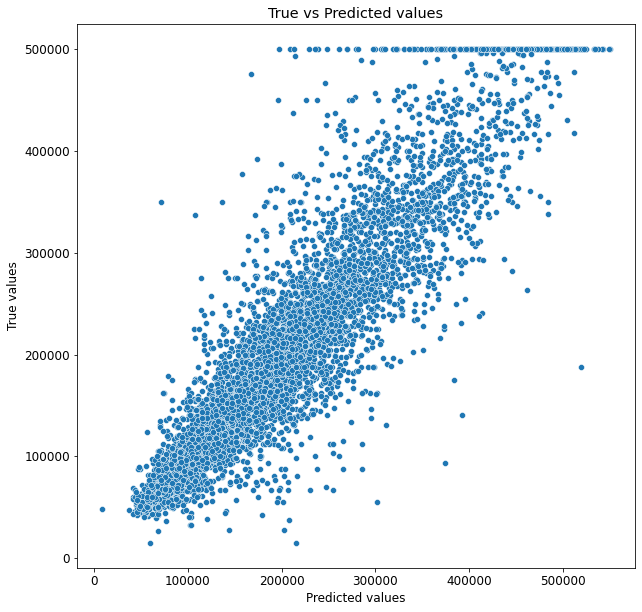

In [53]:
y_test_preds = final_model.predict(X_test_cluster)
evaluate_preds(y_test, y_test_preds)

*Без фичей с кластерами было 0.808 - см вебинар 4*

In [ ]:
X = np.zeros((len(vc), 2), dtype = int)
X[:,0] = [x for x in vc]    
ver = []

silhouette = []

clusters_range = range(3, 6)
batch_range = range(2, int(len(X)/2))
for n_clusters in (clusters_range):
    for batch in (batch_range):
        silhouette_avg = 0
        try:
            clusterer = MiniBatchKMeans(batch_size=batch, compute_labels=True, init='k-means++', init_size=None, max_iter=10, tol=0.0001, max_no_improvement=10, n_clusters=n_clusters, random_state=random_state, n_init=n_clusters, reassignment_ratio=0.05, verbose=0)
            cluster_labels = clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette.append(silhouette_avg)    
        except:
            pass
        ver.append([silhouette_avg, n_clusters, batch])            
ver = pd.DataFrame(ver, columns = ['silhouette_avg', 'n_clusters', 'batch'])
ver = ver.drop_duplicates(['silhouette_avg', 'n_clusters'], keep='first').reset_index(drop=True)



ind = ver[ver['silhouette_avg'] >= np.mean(ver['silhouette_avg'])].index
ver['cls'] = 0; ver.loc[ind, 'cls'] = 1
ver = ver[ver['cls'] == 1].reset_index(drop=True)
ver = ver[ver['n_clusters'] == np.min(ver['n_clusters'])].reset_index(drop=True)
clusterer = MiniBatchKMeans(batch_size=ver.loc[0, 'batch'], compute_labels=True, init='k-means++', init_size=None, max_iter=10, tol=0.0001, max_no_improvement=10, n_clusters=ver.loc[0, 'n_clusters'], random_state=random_state, n_init=n_clusters, reassignment_ratio=0.05, verbose=0)
labels_M = clusterer.fit_predict(X)

        
        

### Кластеризация: DBSCAN <a class='anchor' id='dbscan'>

Кол-во кластеров не указывается.

**Ключевые моменты:**
1. $\epsilon$ - радиус окружности
2. *min_samples* - количество точек, которые попали в границы окружности
3. *сore points* - ключевые точки (в их окружность попало не менее *min_samples* точек)
4. *border points* - граничные точки (в их окружность попало менее *min_samples* точек, но есть хотя бы одна *core point*)
5. *noise points* - выбросы (в их окружность не попала *core point*)


<img src='images/dbscan.png' width=500>

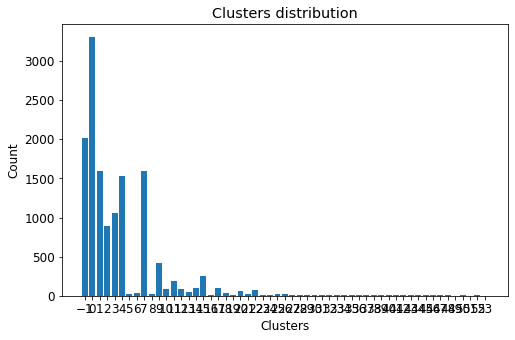

In [54]:
dbscan = DBSCAN(eps=1, min_samples=5)
labels_clast = dbscan.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_dbscan')

# labels_clast_test = dbscan.predict(X_test_scaled)
# labels_clast_test = pd.Series(labels_clast_test, name='clusters_dbscan')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [55]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, labels_clast)

labels_clast_test = knn.predict(X_test_scaled)

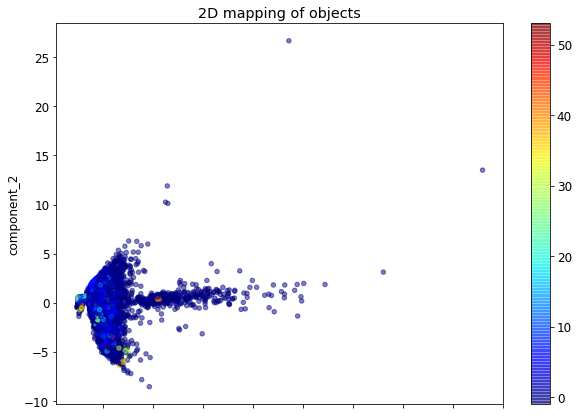

In [56]:
display_components_in_2D_space(components_2d, labels_clast)

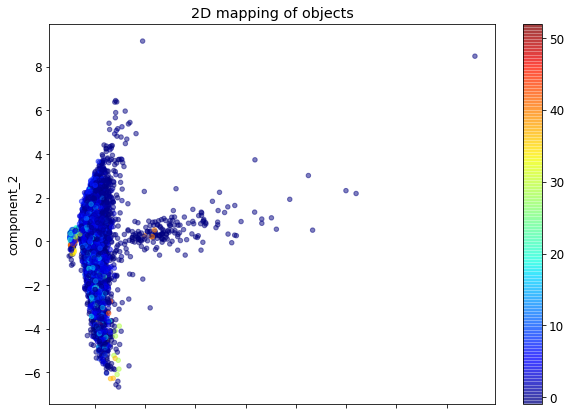

In [57]:
display_components_in_2D_space(components_2d_test, labels_clast_test)

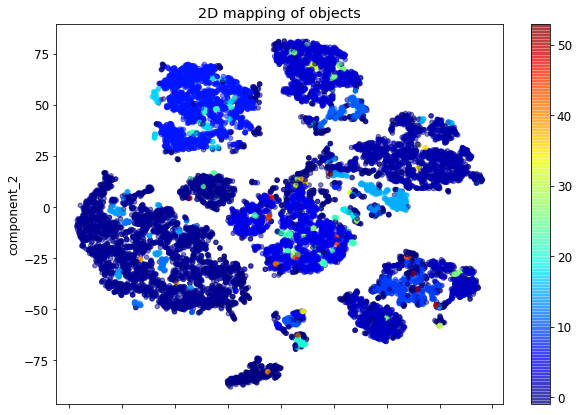

In [58]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

### Кластеризация: Иерархическая <a class='anchor' id='aggl'>
**Агломеративная**

Кол-во кластеров указывается.

**Алгоритм**:
1. Считаем, что каждая точка - кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Пару ближайших кластеров склеиваем в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер


<img src='images/Hierarchical.gif' width=500>

**Методы объединения точек:**
* Single linkage — минимум попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=min||x_i−x_j||$

* Complete linkage — максимум попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=max||x_i−x_j||$

* Average linkage — среднее попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=\frac{1}{n_in_j}∑_{x_i∈C_i}∑_{x_j∈C_j}||xi−xj||$
* Centroid linkage — расстояние между центроидами двух кластеров
$d(C_i,C_j)=||μ_i−μ_j||$

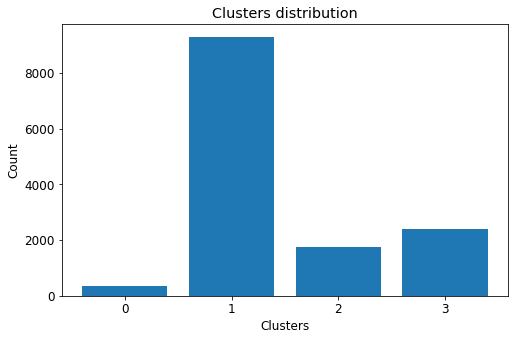

CPU times: user 6.49 s, sys: 537 ms, total: 7.03 s
Wall time: 7.11 s


In [59]:
%%time
aggl = AgglomerativeClustering(n_clusters=4)
labels_clast = aggl.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_aggl')

# labels_clast_test = aggl.predict(X_test_scaled)
# labels_clast_test = pd.Series(labels_clast_test, name='clusters_aggl')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [60]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, labels_clast)

labels_clast_test = knn.predict(X_test_scaled)

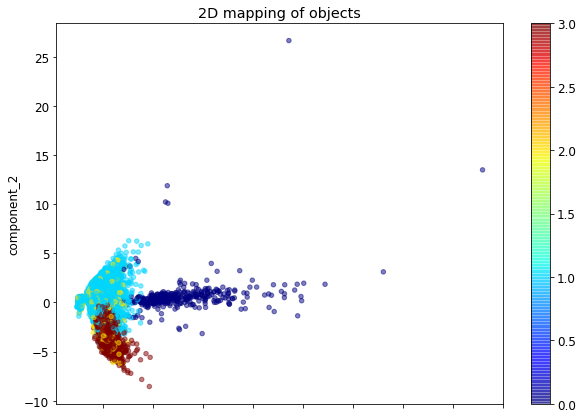

In [61]:
display_components_in_2D_space(components_2d, labels_clast)

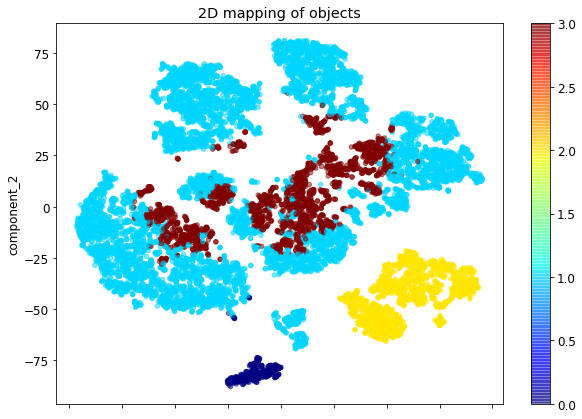

In [62]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

[Plot Hierarchical Clustering Dendrogram¶
](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [63]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

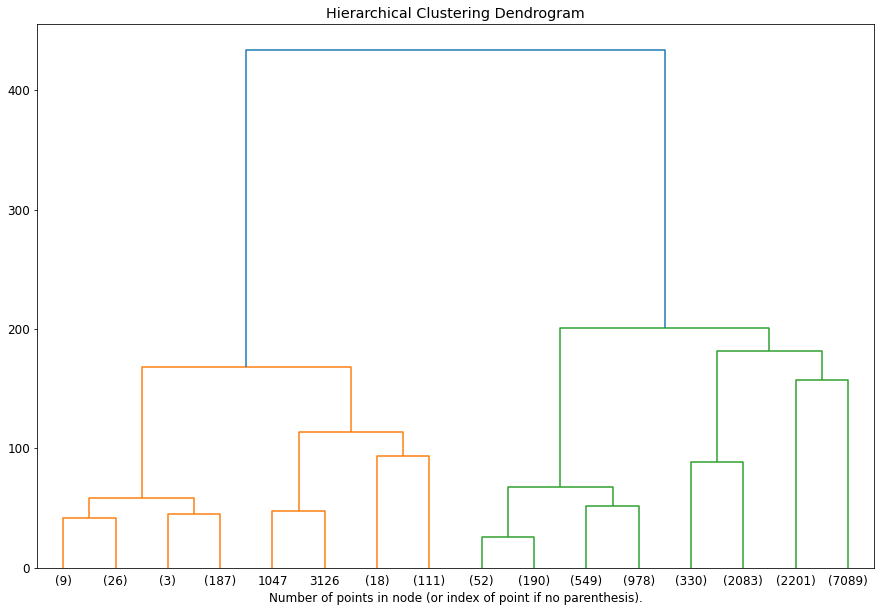

In [64]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_train_scaled)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Более наглядный пример <a class='anchor' id='example'>

Визуализация набора данных MNIST из [статьи](https://habr.com/ru/company/ods/blog/325654/)

In [65]:
from sklearn import datasets


digits = datasets.load_digits()
X = digits.data
y = digits.target

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [67]:
y[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [68]:
X.shape

(1797, 64)

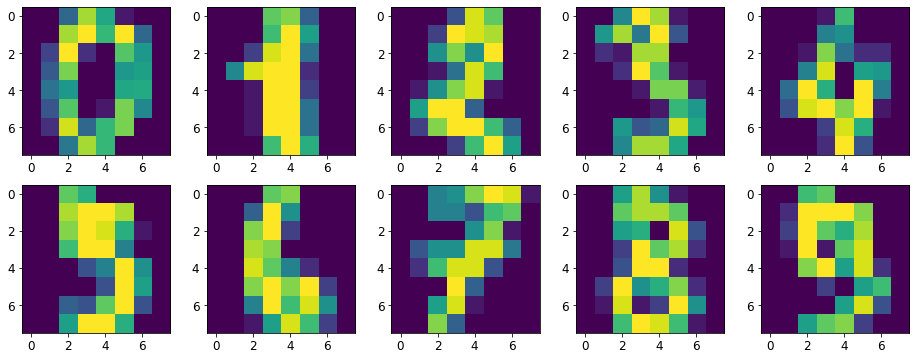

In [69]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]))

**PCA**

In [70]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

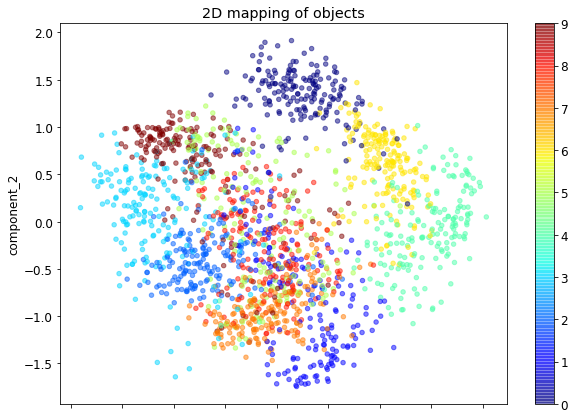

In [71]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_reduced = pd.DataFrame(data=X_reduced, columns=colnames)
components_X_reduced.head()

display_components_in_2D_space(components_X_reduced, labels=y)

**TSNE**

In [72]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, perplexity=25)

X_tsne = tsne.fit_transform(X)

CPU times: user 51.8 s, sys: 534 ms, total: 52.3 s
Wall time: 3.57 s


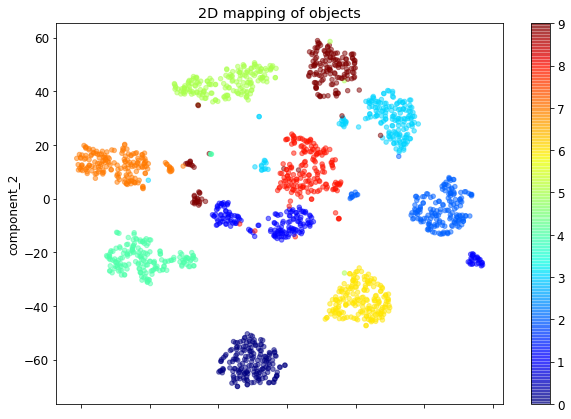

In [73]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_tsne = pd.DataFrame(data=X_tsne, columns=colnames)
components_X_tsne.head()

display_components_in_2D_space(components_X_tsne, labels=y)

**KMeans**

In [74]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels_clast = kmeans.fit_predict(X)
labels_clast = pd.Series(labels_clast, name='clusters')

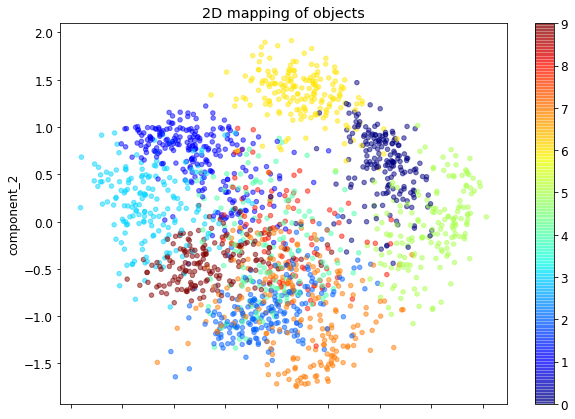

In [75]:
display_components_in_2D_space(components_X_reduced, labels=labels_clast)

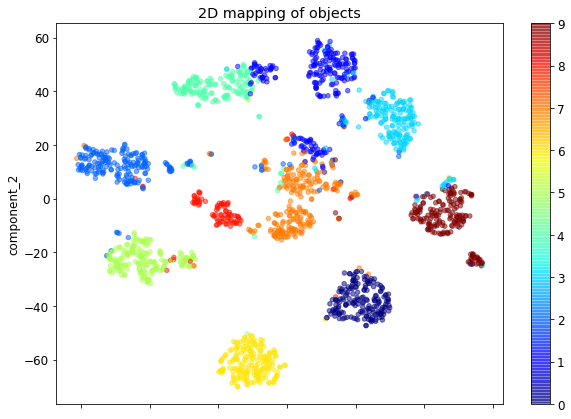

In [76]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

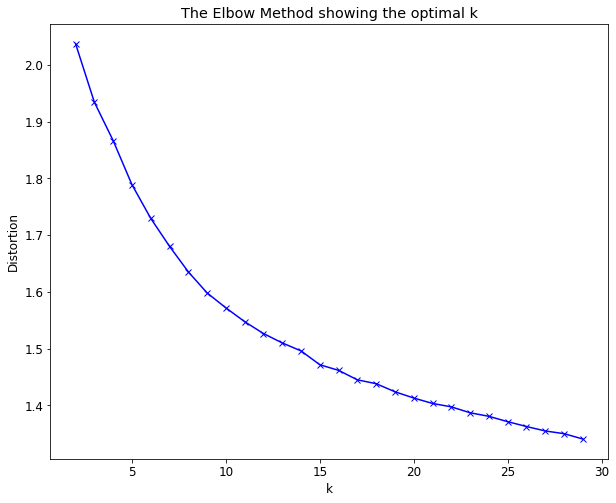

In [77]:
apply_elbow_method(X)

**DBSCAN**

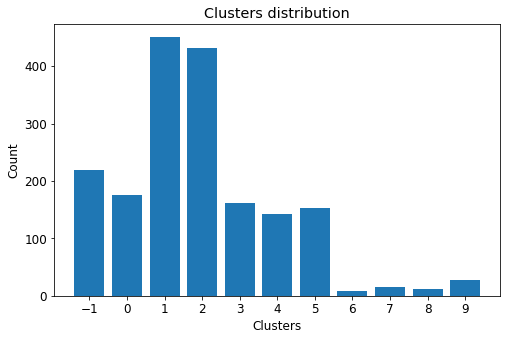

In [78]:
dbscan = DBSCAN(eps=1.4, min_samples=5)
labels_clast = dbscan.fit_predict(X)
labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

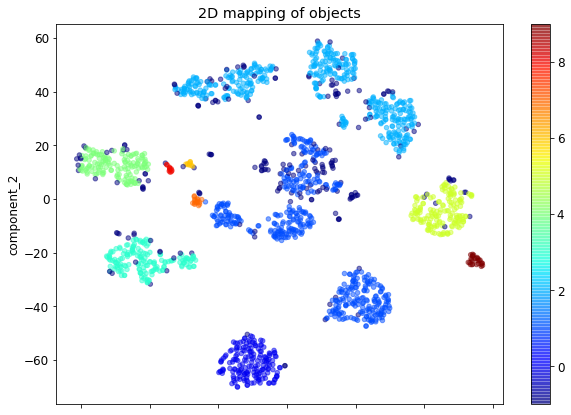

In [79]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

**AgglomerativeClustering**

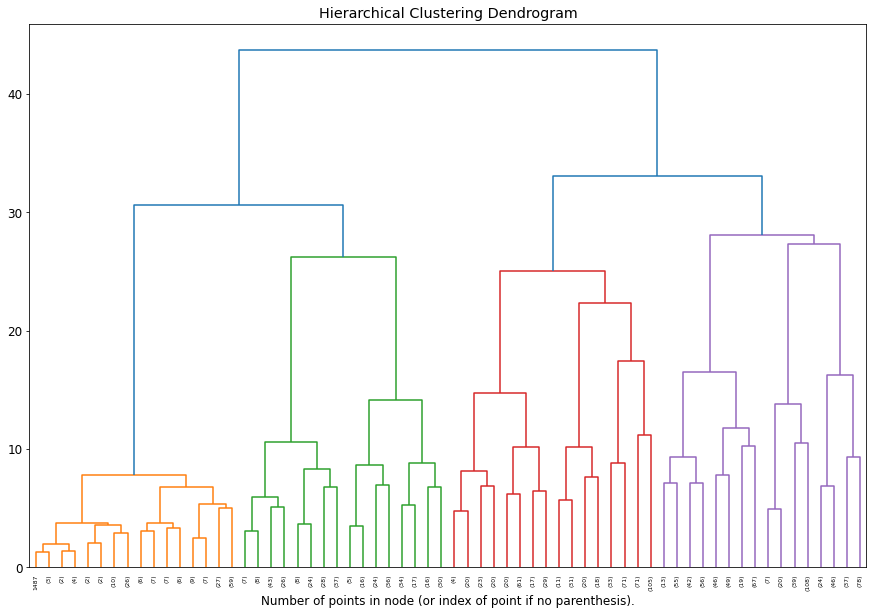

In [80]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram

plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

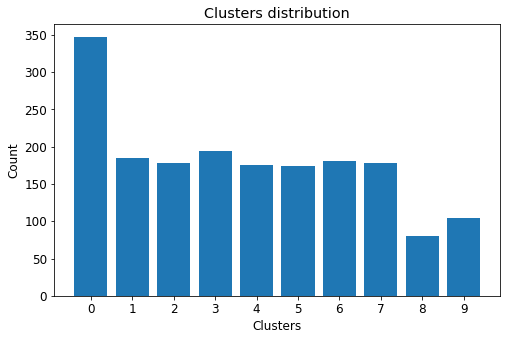

CPU times: user 185 ms, sys: 10.6 ms, total: 196 ms
Wall time: 195 ms


In [81]:
%%time
aggl = AgglomerativeClustering(n_clusters=10)
labels_clast = aggl.fit_predict(X)
labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [82]:
# display_components_in_2D_space(components_X_tsne, labels=y)

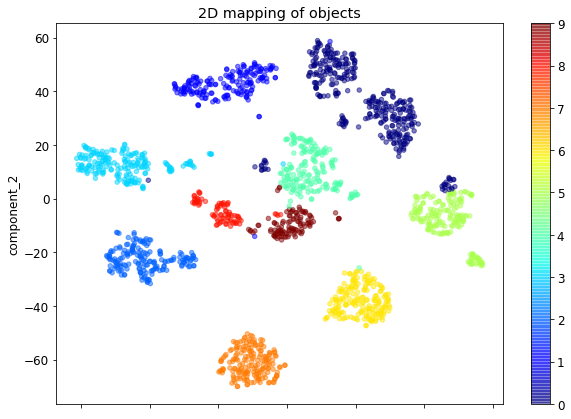

In [83]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

### Задание для курсового проекта <a class='anchor' id='course'>
    
https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528
    
    
Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline
    
    

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 10.01.21
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 